# Implementing Diffusion Models

## Preprocess Data

In [1]:
import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Expand dimensions to match the input shape (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

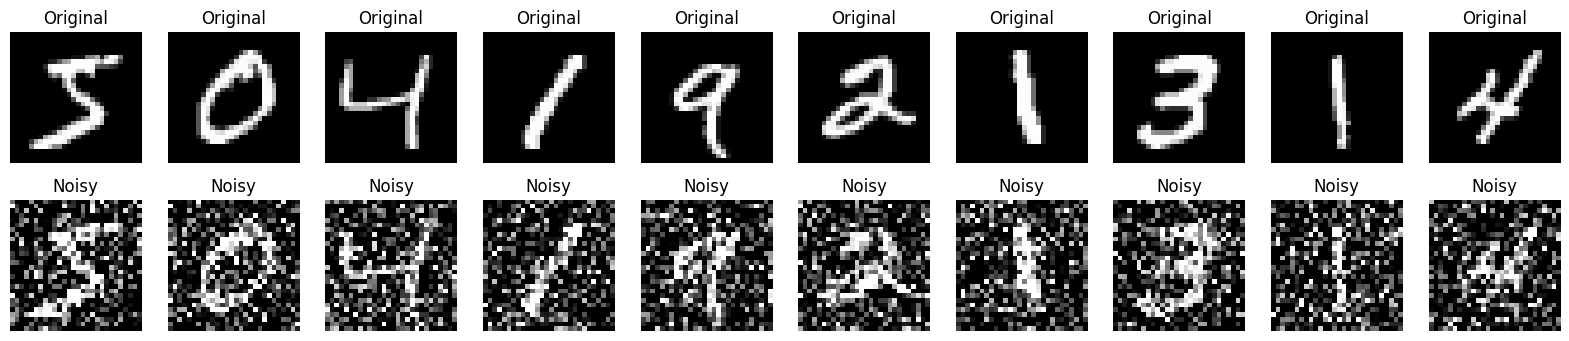

In [6]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].squeeze(), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')
plt.show()

## Build the diffusion model

In [8]:
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer) # Reduced Filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # Reduced Filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x) # Reduced size
x = Dense(28*28*32, activation='relu')(x) # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x) # Reduced Filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x) # Reduced Filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error') # using MSE for regression tasks

diffusion_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

## Add Noise to the data

In [10]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size


## Train the diffusion model

In [11]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 140s 148ms/step - loss: 0.0323 - val_loss: 0.0159
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 144s 153ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 140s 149ms/step - loss: 0.0111 - val_loss: 0.0123


## Evaluate the Diffusion Model


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step


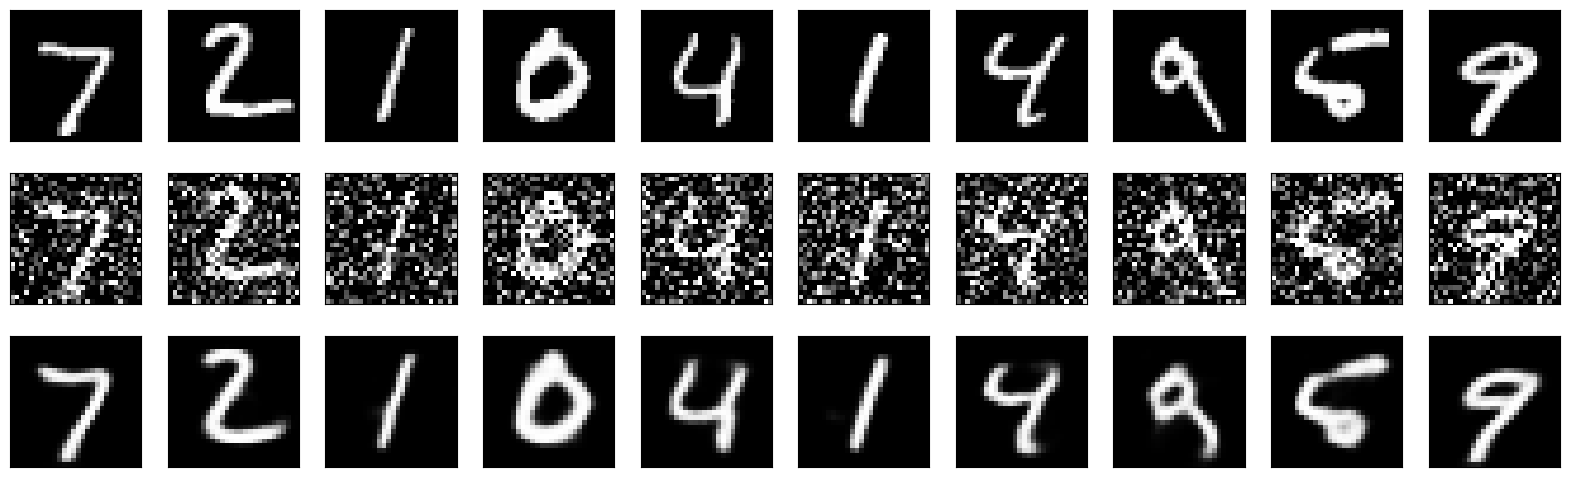

In [12]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()